In [1]:
%pip install pandas numpy seaborn scikit-learn matplotlib tensorflow xgboost lightgbm shap keras optuna kagglehub gputil imbalanced-learn pynvml

Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import logging
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    f1_score,
    make_scorer,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import RobustScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf

# Import shared utilities
from IPython.display import display
import os

sys.path.append("../../")  # Add parent directory to path for imports
from utils.measurements import measure_resources
from utils.evaluations import evaluate_model
from utils.callbacks import EarlyStoppingCallback, ThresholdStopper
from utils.visualization import plot_optuna_attributes
from objectives_func.ensembles.xgb import objective_xgb
from objectives_func.ensembles.lgbm import objective_lgbm

c:\Users\pc\anaconda3\envs\eval_ids_1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.list_physical_devices("GPU")
gpu_available = len(gpus) > 0
print(f"GPU available: {gpu_available}")

GPU available: False


**Import data**

In [3]:
os.chdir("../..")
display(os.getcwd())

'c:\\Users\\pc\\Documents\\researches\\models\\ensemble'

In [4]:
X_train_resampled_scaled = np.load("./data/trainable/X_train_resampled_scaled.npy")
y_train_resampled_scaled = np.load("data/trainable/Y_train_resampled_scaled.npy")
X_test = np.load("data/trainable/X_test.npy")
y_test = np.load("data/trainable/Y_test.npy")

FileNotFoundError: [Errno 2] No such file or directory: './data/trainable/X_train_resampled_scaled.npy'

## **Objective functions**

# Normalize and split train/cv/test sets

In [35]:
# Initializing the undersampling for the clean df
X_train_resampled, y_train_resampled = RandomUnderSampler(
    sampling_strategy={"Normal Traffic": 500000}, random_state=42
).fit_resample(X_train, y_train)

# Initializing the undersampling for the scaled df
X_train_scaled, y_train_scaled = RandomUnderSampler(
    sampling_strategy={"Normal Traffic": 500000}, random_state=42
).fit_resample(X_train_scaled, y_train)

Oversampling minor classes with SMOTE

In [36]:
X_train_resampled_scaled, y_train_resampled_scaled = SMOTE(
    sampling_strategy={
        "Bots": 2000,
        "Web Attacks": 2000,
        "Brute Force": 7000,
        "Port Scanning": 70000,
        "DDoS": 90000,
        "DoS": 200000,
    },
    random_state=42,
).fit_resample(X_train_scaled, y_train_scaled)

In [37]:
y_train_resampled_scaled.value_counts()

,count
Attack Type,
Normal Traffic,500000
DoS,200000
DDoS,90000
Port Scanning,70000
Brute Force,7000
Bots,2000
Web Attacks,2000


<Axes: xlabel='count', ylabel='Attack Type'>

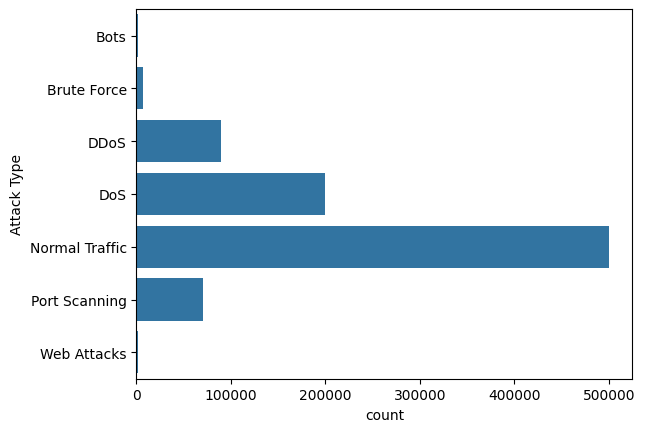

In [38]:
sns.countplot(y=y_train_resampled_scaled)

In [39]:
y_train_resampled_scaled = y_train_resampled_scaled.map(
    {
        "Normal Traffic": 0,
        "Web Attacks": 1,
        "Brute Force": 1,
        "Port Scanning": 1,
        "DDoS": 1,
        "DoS": 1,
        "Bots": 1,
    }
)

In [40]:
y_test = y_test.map(
    {
        "Normal Traffic": 0,
        "Web Attacks": 1,
        "Brute Force": 1,
        "Port Scanning": 1,
        "DDoS": 1,
        "DoS": 1,
        "Bots": 1,
    }
)

# Ensemble learning

In [41]:
DEAFAULT_N_TRIALS = 30

In [59]:
early_stop = EarlyStoppingCallback(patience=5, threshold=0.05, direction="maximize")
threshold_stop = ThresholdStopper(threshold=0.99)

## XGBoost Classfier
### Fine-tuning

In [83]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(
    lambda trial: objective_xgb(
        trial,
        xgb.XGBClassifier,
        X_train_resampled_scaled,
        y_train_resampled_scaled,
        X_test_scaled,
        y_test,
    ),
    n_trials=DEAFAULT_N_TRIALS,
    callbacks=[early_stop, threshold_stop],
)


[I 2025-09-30 08:55:50,532] A new study created in memory with name: no-name-91ba755e-eb83-4f53-9e33-14b34788b3e8


A new study created in memory with name: no-name-91ba755e-eb83-4f53-9e33-14b34788b3e8
A new study created in memory with name: no-name-91ba755e-eb83-4f53-9e33-14b34788b3e8
A new study created in memory with name: no-name-91ba755e-eb83-4f53-9e33-14b34788b3e8
A new study created in memory with name: no-name-91ba755e-eb83-4f53-9e33-14b34788b3e8
A new study created in memory with name: no-name-91ba755e-eb83-4f53-9e33-14b34788b3e8


/tmp/ipython-input-3295655845.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.3),
/tmp/ipython-input-3295655845.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 10.0),
/tmp/ipython-input-3295655845.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
[I 2025-09-30 08:58:41,748] Trial 0 finished with value: 0.9923672610678953 and par

Trial 0 finished with value: 0.9923672610678953 and parameters: {'booster': 'dart', 'max_depth': 6, 'learning_rate': 0.14670846775978483, 'n_estimators': 439, 'min_child_weight': 2, 'gamma': 6.132156238871705, 'subsample': 0.8836616012403755, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.9714121096008967, 'colsample_bylevel': 0.6241494570629733, 'colsample_bynode': 0.950771955929675, 'alpha': 0.0344031684984053, 'lambda': 7.743356210681074e-06, 'scale_pos_weight': 4.730971676946723, 'grow_policy': 'lossguide', 'max_leaves': 135, 'max_bin': 306, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.35413840868460467, 'skip_drop': 0.03126551578097936}. Best is trial 0 with value: 0.9923672610678953.
Trial 0 finished with value: 0.9923672610678953 and parameters: {'booster': 'dart', 'max_depth': 6, 'learning_rate': 0.14670846775978483, 'n_estimators': 439, 'min_child_weight': 2, 'gamma': 6.132156238871705, 'subsample': 0.8836616012403755, 'sampling_method': 'gra

**Best params after `n_rounds=5`** (with early stopping)

In [84]:
xgb_study.best_params

{'booster': 'dart',
 'max_depth': 6,
 'learning_rate': 0.14670846775978483,
 'n_estimators': 439,
 'min_child_weight': 2,
 'gamma': 6.132156238871705,
 'subsample': 0.8836616012403755,
 'sampling_method': 'gradient_based',
 'colsample_bytree': 0.9714121096008967,
 'colsample_bylevel': 0.6241494570629733,
 'colsample_bynode': 0.950771955929675,
 'alpha': 0.0344031684984053,
 'lambda': 7.743356210681074e-06,
 'scale_pos_weight': 4.730971676946723,
 'grow_policy': 'lossguide',
 'max_leaves': 135,
 'max_bin': 306,
 'sample_type': 'weighted',
 'normalize_type': 'tree',
 'rate_drop': 0.35413840868460467,
 'skip_drop': 0.03126551578097936}

In [85]:
xgb_study.best_trial

FrozenTrial(number=0, state=1, values=[0.9923672610678953], datetime_start=datetime.datetime(2025, 9, 30, 8, 55, 50, 535762), datetime_complete=datetime.datetime(2025, 9, 30, 8, 58, 41, 748392), params={'booster': 'dart', 'max_depth': 6, 'learning_rate': 0.14670846775978483, 'n_estimators': 439, 'min_child_weight': 2, 'gamma': 6.132156238871705, 'subsample': 0.8836616012403755, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.9714121096008967, 'colsample_bylevel': 0.6241494570629733, 'colsample_bynode': 0.950771955929675, 'alpha': 0.0344031684984053, 'lambda': 7.743356210681074e-06, 'scale_pos_weight': 4.730971676946723, 'grow_policy': 'lossguide', 'max_leaves': 135, 'max_bin': 306, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.35413840868460467, 'skip_drop': 0.03126551578097936}, user_attrs={'train_time_sec': 29.66147208213806, 'test_time_sec': 0.9803593158721924, 'cpu_usage_percent_train': 128.5, 'memory_usage_mb_train': 6961.53515625, 'gpu_util_percen

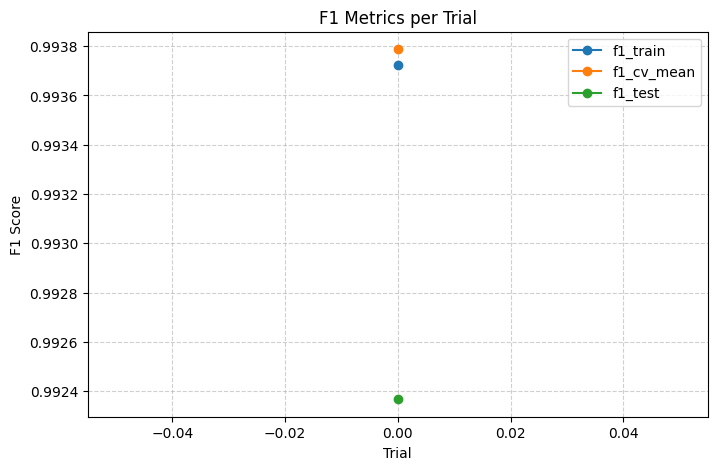

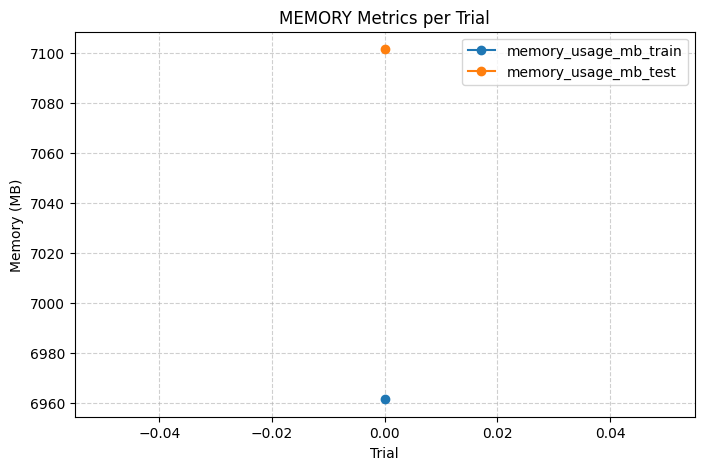

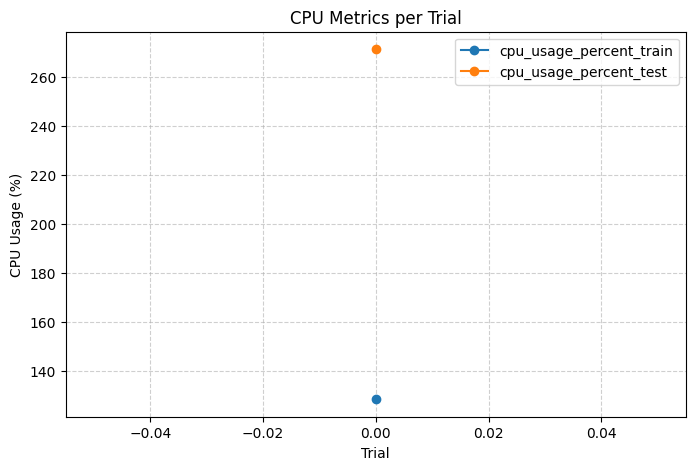

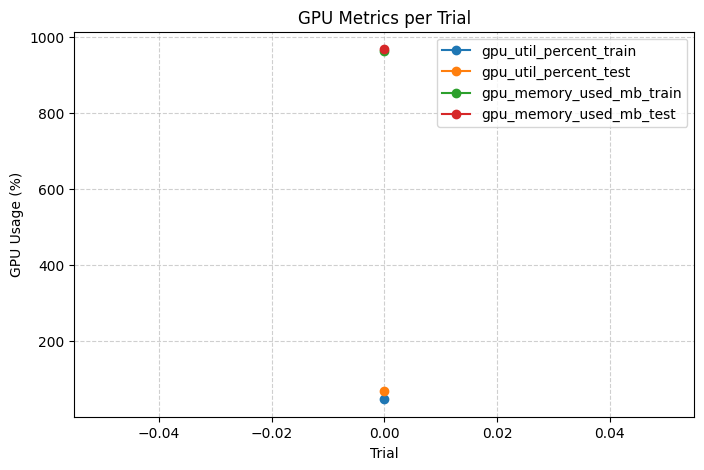

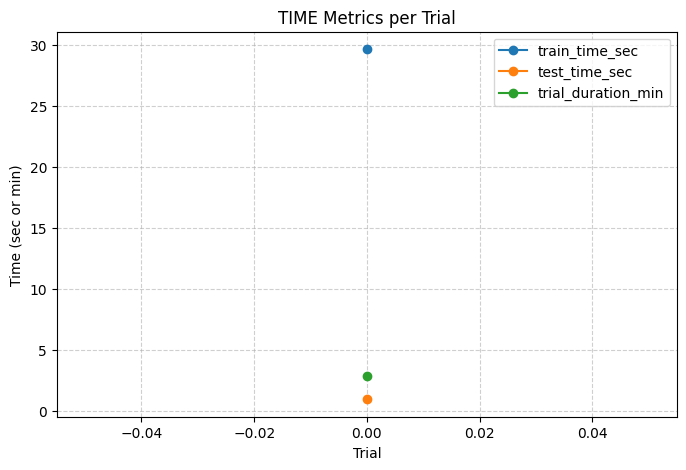

In [86]:
plot_optuna_attributes(xgb_study)

**Best parameters for `XGBClassifier`**
```python
{
    'booster': 'dart',
    'max_depth': 6,
    'learning_rate': 0.14670846775978483,
    'n_estimators': 439,
    'min_child_weight': 2,
    'gamma': 6.132156238871705,
    'subsample': 0.8836616012403755,
    'sampling_method': 'gradient_based',
    'colsample_bytree': 0.9714121096008967,
    'colsample_bylevel': 0.6241494570629733,
    'colsample_bynode': 0.950771955929675,
    'alpha': 0.0344031684984053,
    'lambda': 7.743356210681074e-06,
    'scale_pos_weight': 4.730971676946723,
    'grow_policy': 'lossguide',
    'max_leaves': 135,
    'max_bin': 306,
    'sample_type': 'weighted',
    'normalize_type': 'tree',
    'rate_drop': 0.35413840868460467,
    'skip_drop': 0.03126551578097936
}
```

In [ ]:
xgb_clf_best_params = {
    "objective": "binary:logistic",
    "device": "cuda",
    "verbosity": 1,
    "eval_metric": "logloss",
    "booster": "dart",
    "max_depth": 6,
    "learning_rate": 0.14670846775978483,
    "n_estimators": 439,
    "min_child_weight": 2,
    "gamma": 6.132156238871705,
    "subsample": 0.8836616012403755,
    "sampling_method": "gradient_based",
    "colsample_bytree": 0.9714121096008967,
    "colsample_bylevel": 0.6241494570629733,
    "colsample_bynode": 0.950771955929675,
    "alpha": 0.0344031684984053,
    "lambda": 7.743356210681074e-06,
    "scale_pos_weight": 4.730971676946723,
    "grow_policy": "lossguide",
    "max_leaves": 135,
    "max_bin": 306,
    "sample_type": "weighted",
    "normalize_type": "tree",
    "rate_drop": 0.35413840868460467,
    "skip_drop": 0.03126551578097936,
}

### Retrain with best parameters

In [88]:
best_xgbc = xgb.XGBClassifier(**xgb_clf_best_params)
results_train_xgb = measure_resources(
    best_xgbc.fit, X_train_resampled_scaled, y_train_resampled_scaled
)

In [128]:
results_train_xgb

{'result': XGBClassifier(alpha=0.0344031684984053, base_score=None, booster='dart',
               callbacks=None, colsample_bylevel=0.6241494570629733,
               colsample_bynode=0.950771955929675,
               colsample_bytree=0.9714121096008967, device='cuda',
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', feature_types=None, feature_weights=None,
               gamma=6.132156238871705, grow_policy='lossguide',
               importance_type=None, interaction_constraints=None,
               lambda=7.743356210681074e-06, learning_rate=0.14670846775978483,
               max_bin=306, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=135,
               min_child_weight=2, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=439, ...),
 'elapsed_time_sec': 29.312398672103882,
 'cpu_usage': 129.7,
 'python_peak_memory_mb': 6977

In [136]:
for key, value in results_train_xgb.items():
    if key != "result":
        print(f"{key} at train time: {value}")

elapsed_time_sec at train time: 29.312398672103882
cpu_usage at train time: 129.7
python_peak_memory_mb at train time: 6977.60546875
gpu_util_percent at train time: 46
gpu_memory_used_mb at train time: 963.125


In [98]:
cross_vl = cross_val_score(
    best_xgbc, X_train_resampled_scaled, y_train_resampled_scaled, cv=5
)

Cross-validation score of XBGoost: [0.99162457 0.9947589  0.99438576 0.9947302  0.99307118]


In [129]:
print("Cross-validation score of XBGoost:", np.mean(cross_vl))

Cross-validation score of XBGoost: 0.9937141216991963


In [134]:
start = time.time()
results_test_xgb = measure_resources(best_xgbc.predict, X_test_scaled)
y_pred_xgb = results_test_xgb["result"]
end = time.time()
print(f"Time to detect XGBoost: {(end - start) / len(y_test)}")

Time to detect XGBoost: 1.4617778517594071e-06


In [135]:
for key, value in results_test_xgb.items():
    if key != "result":
        print(f"{key} at test: {value}")

elapsed_time_sec at test: 1.0045759677886963
cpu_usage at test: 250.9
python_peak_memory_mb at test: 7143.23046875
gpu_util_percent at test: 87
gpu_memory_used_mb at test: 967.125


In [131]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    628518
           1       0.96      1.00      0.98    127708

    accuracy                           0.99    756226
   macro avg       0.98      0.99      0.99    756226
weighted avg       0.99      0.99      0.99    756226



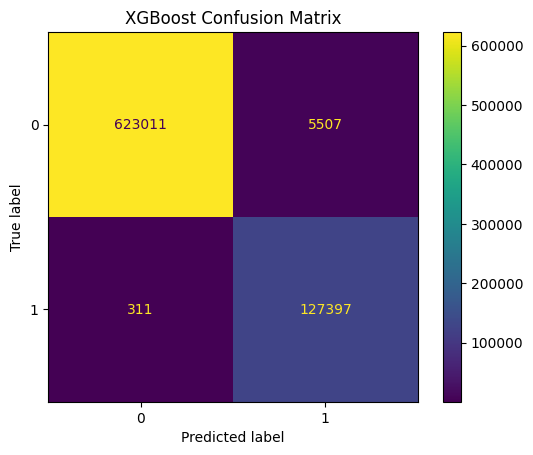

In [ ]:
xgb_confusion = confusion_matrix(y_test, y_pred)
xgb_cm_display = ConfusionMatrixDisplay(
    confusion_matrix=xgb_confusion, display_labels=[0, 1]
)

xgb_cm_display.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

In [ ]:
print(f"Time to detect XGBoost: {(results_test_xgb['elapsed_time_sec'] / len(y_test))}")

Time to detect XGBoost: 1.418881323087902e-06


**Save models**

In [ ]:
import pickle

file_name = "xgb_cicids2017.pkl"
# save
pickle.dump(best_xgbc, open(file_name, "wb"))


## LightGBM

In [ ]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
lgbm_study = optuna.create_study(direction="maximize")
lgbm_study.optimize(
    lambda trial: objective_lgbm(
        trial,
        lgb.LGBMClassifier,
        X_train_resampled_scaled,
        y_train_resampled_scaled,
        X_test_scaled,
        y_test,
    ),
    n_trials=DEAFAULT_N_TRIALS,
    callbacks=[early_stop, threshold_stop],
)

[I 2025-09-30 09:10:09,949] A new study created in memory with name: no-name-561d9ea1-a904-4f73-b773-e8b3a17cc298


A new study created in memory with name: no-name-561d9ea1-a904-4f73-b773-e8b3a17cc298
A new study created in memory with name: no-name-561d9ea1-a904-4f73-b773-e8b3a17cc298
A new study created in memory with name: no-name-561d9ea1-a904-4f73-b773-e8b3a17cc298
A new study created in memory with name: no-name-561d9ea1-a904-4f73-b773-e8b3a17cc298
A new study created in memory with name: no-name-561d9ea1-a904-4f73-b773-e8b3a17cc298
A new study created in memory with name: no-name-561d9ea1-a904-4f73-b773-e8b3a17cc298


/tmp/ipython-input-2472037621.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.3),
/tmp/ipython-input-2472037621.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-4, 1e2),
/tmp/ipython-input-2472037621.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
/tmp/ipython-input-2472037621.py:21: FutureWarning: sugg

[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 will be ignored. Current value: feature_fraction=0.7413624617854249
[LightGBM] [Warning] lambda_l2 is set=0.004153878048403622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004153878048403622
[LightGBM] [Warning] lambda_l1 is set=6.032003134359353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.032003134359353e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7457130683737984 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 will be ignored. Current value: feature_fraction=0.7413624617854249
[LightGBM] [Warning] lambda_l2 is set=0.004153878048403622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004153878048403622
[LightGBM] [Warning] lambda_l1 is set=6.032003134359353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.032003134359353e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7457130683737984 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 will be ignored. Current value: feature_fraction=0.7413624617854249
[LightGBM] [Warning] lambda_l2 is set=0.004153878048403622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004153878048403622
[LightGBM] [Warning] lambda_l1 is set=6.032003134359353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.032003134359353e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7457130683737984 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 will be ignored. Current value: feature_fraction=0.7413624617854249
[LightGBM] [Warning] lambda_l2 is set=0.004153878048403622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004153878048403622
[LightGBM] [Warning] lambda_l1 is set=6.032003134359353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.032003134359353e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7457130683737984 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 will be ignored. Current value: feature_fraction=0.7413624617854249
[LightGBM] [Warning] lambda_l2 is set=0.004153878048403622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004153878048403622
[LightGBM] [Warning] lambda_l1 is set=6.032003134359353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.032003134359353e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7457130683737984 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 will be ignored. Current value: feature_fraction=0.7413624617854249
[LightGBM] [Warning] lambda_l2 is set=0.004153878048403622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004153878048403622
[LightGBM] [Warning] lambda_l1 is set=6.032003134359353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.032003134359353e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7457130683737984 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7413624617854249, colsample_bytree=0.7448752405559612 will be ignored. Current value: feature_fraction=0.7413624617854249
[LightGBM] [Warning] lambda_l2 is set=0.004153878048403622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004153878048403622
[LightGBM] [Warning] lambda_l1 is set=6.032003134359353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.032003134359353e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7457130683737984 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


[I 2025-09-30 09:11:00,904] Trial 0 finished with value: 0.7544741048838146 and parameters: {'boosting_type': 'goss', 'num_leaves': 183, 'max_depth': 3, 'learning_rate': 0.00010706574699577312, 'n_estimators': 415, 'subsample': 0.7457130683737984, 'tree_learner': 'voting', 'colsample_bytree': 0.7448752405559612, 'min_child_samples': 92, 'min_child_weight': 4.93149156157469, 'lambda_l1': 6.032003134359353e-05, 'lambda_l2': 0.004153878048403622, 'extra_trees': True, 'feature_fraction': 0.7413624617854249}. Best is trial 0 with value: 0.7544741048838146.


Trial 0 finished with value: 0.7544741048838146 and parameters: {'boosting_type': 'goss', 'num_leaves': 183, 'max_depth': 3, 'learning_rate': 0.00010706574699577312, 'n_estimators': 415, 'subsample': 0.7457130683737984, 'tree_learner': 'voting', 'colsample_bytree': 0.7448752405559612, 'min_child_samples': 92, 'min_child_weight': 4.93149156157469, 'lambda_l1': 6.032003134359353e-05, 'lambda_l2': 0.004153878048403622, 'extra_trees': True, 'feature_fraction': 0.7413624617854249}. Best is trial 0 with value: 0.7544741048838146.
Trial 0 finished with value: 0.7544741048838146 and parameters: {'boosting_type': 'goss', 'num_leaves': 183, 'max_depth': 3, 'learning_rate': 0.00010706574699577312, 'n_estimators': 415, 'subsample': 0.7457130683737984, 'tree_learner': 'voting', 'colsample_bytree': 0.7448752405559612, 'min_child_samples': 92, 'min_child_weight': 4.93149156157469, 'lambda_l1': 6.032003134359353e-05, 'lambda_l2': 0.004153878048403622, 'extra_trees': True, 'feature_fraction': 0.7413624

/tmp/ipython-input-2472037621.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.3),
/tmp/ipython-input-2472037621.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-4, 1e2),
/tmp/ipython-input-2472037621.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
/tmp/ipython-input-2472037621.py:21: FutureWarning: sugg

[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.9732773502317136 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.777924629700373

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.9732773502317136 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.777924629700373

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.9732773502317136 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.777924629700373

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.9732773502317136 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.777924629700373

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.9732773502317136 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.777924629700373

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.9732773502317136 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.777924629700373

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.9732773502317136 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


[I 2025-09-30 09:12:43,102] Trial 1 finished with value: 0.9985687197621042 and parameters: {'boosting_type': 'goss', 'num_leaves': 54, 'max_depth': 6, 'learning_rate': 0.03168606336446395, 'n_estimators': 376, 'subsample': 0.9732773502317136, 'tree_learner': 'serial', 'colsample_bytree': 0.7779246297003738, 'min_child_samples': 46, 'min_child_weight': 0.0049656088026181445, 'lambda_l1': 3.485203479609063e-07, 'lambda_l2': 0.0012932480056061738, 'extra_trees': False, 'feature_fraction': 0.8969128906566174}. Best is trial 1 with value: 0.9985687197621042.


Trial 1 finished with value: 0.9985687197621042 and parameters: {'boosting_type': 'goss', 'num_leaves': 54, 'max_depth': 6, 'learning_rate': 0.03168606336446395, 'n_estimators': 376, 'subsample': 0.9732773502317136, 'tree_learner': 'serial', 'colsample_bytree': 0.7779246297003738, 'min_child_samples': 46, 'min_child_weight': 0.0049656088026181445, 'lambda_l1': 3.485203479609063e-07, 'lambda_l2': 0.0012932480056061738, 'extra_trees': False, 'feature_fraction': 0.8969128906566174}. Best is trial 1 with value: 0.9985687197621042.
Trial 1 finished with value: 0.9985687197621042 and parameters: {'boosting_type': 'goss', 'num_leaves': 54, 'max_depth': 6, 'learning_rate': 0.03168606336446395, 'n_estimators': 376, 'subsample': 0.9732773502317136, 'tree_learner': 'serial', 'colsample_bytree': 0.7779246297003738, 'min_child_samples': 46, 'min_child_weight': 0.0049656088026181445, 'lambda_l1': 3.485203479609063e-07, 'lambda_l2': 0.0012932480056061738, 'extra_trees': False, 'feature_fraction': 0.8

In [107]:
lgbm_study.trials

[FrozenTrial(number=0, state=1, values=[0.7544741048838146], datetime_start=datetime.datetime(2025, 9, 30, 9, 10, 9, 952932), datetime_complete=datetime.datetime(2025, 9, 30, 9, 11, 0, 904128), params={'boosting_type': 'goss', 'num_leaves': 183, 'max_depth': 3, 'learning_rate': 0.00010706574699577312, 'n_estimators': 415, 'subsample': 0.7457130683737984, 'tree_learner': 'voting', 'colsample_bytree': 0.7448752405559612, 'min_child_samples': 92, 'min_child_weight': 4.93149156157469, 'lambda_l1': 6.032003134359353e-05, 'lambda_l2': 0.004153878048403622, 'extra_trees': True, 'feature_fraction': 0.7413624617854249}, user_attrs={'train_time_sec': 8.53581976890564, 'test_time_sec': 2.1319172382354736, 'cpu_usage_percent_train': 580.9, 'memory_usage_mb_train': 6930.7890625, 'gpu_util_percent_train': 19, 'gpu_memory_used_mb_train': 967.125, 'cpu_usage_percent_test': 573.3, 'memory_usage_mb_test': 6811.06640625, 'gpu_util_percent_test': 0, 'gpu_memory_used_mb_test': 967.125, 'f1_train': 0.418711

In [108]:
lgbm_study.best_params

{'boosting_type': 'goss',
 'num_leaves': 54,
 'max_depth': 6,
 'learning_rate': 0.03168606336446395,
 'n_estimators': 376,
 'subsample': 0.9732773502317136,
 'tree_learner': 'serial',
 'colsample_bytree': 0.7779246297003738,
 'min_child_samples': 46,
 'min_child_weight': 0.0049656088026181445,
 'lambda_l1': 3.485203479609063e-07,
 'lambda_l2': 0.0012932480056061738,
 'extra_trees': False,
 'feature_fraction': 0.8969128906566174}

In [ ]:
lgbm_best_params = {
    "objective": "binary",
    "device": "gpu",
    "verbosity": 0,
    "eval_metric": "logloss",
    "boosting_type": "goss",
    "num_leaves": 54,
    "max_depth": 6,
    "learning_rate": 0.03168606336446395,
    "n_estimators": 376,
    "subsample": 0.9732773502317136,
    "tree_learner": "serial",
    "colsample_bytree": 0.7779246297003738,
    "min_child_samples": 46,
    "min_child_weight": 0.0049656088026181445,
    "lambda_l1": 3.485203479609063e-07,
    "lambda_l2": 0.0012932480056061738,
    "extra_trees": False,
    "feature_fraction": 0.8969128906566174,
}

```python
{
    "objective": "binary",
    "device": "gpu",
    "verbosity": 0,
    "eval_metric": "logloss",
    'boosting_type': 'goss',
    'num_leaves': 54,
    'max_depth': 6,
    'learning_rate': 0.03168606336446395,
    'n_estimators': 376,
    'subsample': 0.9732773502317136,
    'tree_learner': 'serial',
    'colsample_bytree': 0.7779246297003738,
    'min_child_samples': 46,
    'min_child_weight': 0.0049656088026181445,
    'lambda_l1': 3.485203479609063e-07,
    'lambda_l2': 0.0012932480056061738,
    'extra_trees': False,
    'feature_fraction': 0.8969128906566174
}
```

### Retrain `LGBMClassifier` with best parameters

In [139]:
best_lgbm = lgb.LGBMClassifier(**lgbm_best_params)
results_train_lgbm = measure_resources(
    best_lgbm.fit, X_train_resampled_scaled, y_train_resampled_scaled
)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_l

In [140]:
for key, value in results_train_lgbm.items():
    if key != "result":
        print(f"{key}: {value}")

elapsed_time_sec: 17.271663665771484
cpu_usage: 578.5
python_peak_memory_mb: 6974.55859375
gpu_util_percent: 17
gpu_memory_used_mb: 967.125


In [112]:
cross_val_lgbm = cross_val_score(
    best_lgbm, X_train_resampled_scaled, y_train_resampled_scaled, cv=5
)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_l

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_l

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_l

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_l

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_l

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [137]:
print("Cross-validation score of LightGBM:", np.mean(cross_val_lgbm))

Cross-validation score of LightGBM: 0.998324913892078


In [141]:
start = time.time()
results_test_lgbm = measure_resources(best_lgbm.predict, X_test_scaled)
y_pred = results_test_lgbm["result"]
end = time.time()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [142]:
print(f"Time to detect LightGBM: {(end - start) / len(y_test)}")

Time to detect LightGBM: 5.047023568280235e-06


In [143]:
for key, value in results_test_lgbm.items():
    if key != "result":
        print(f"{key}: {value}")

elapsed_time_sec: 3.7715859413146973
cpu_usage: 562.5
python_peak_memory_mb: 6849.328125
gpu_util_percent: 0
gpu_memory_used_mb: 967.125


In [122]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628518
           1       0.99      1.00      1.00    127708

    accuracy                           1.00    756226
   macro avg       1.00      1.00      1.00    756226
weighted avg       1.00      1.00      1.00    756226



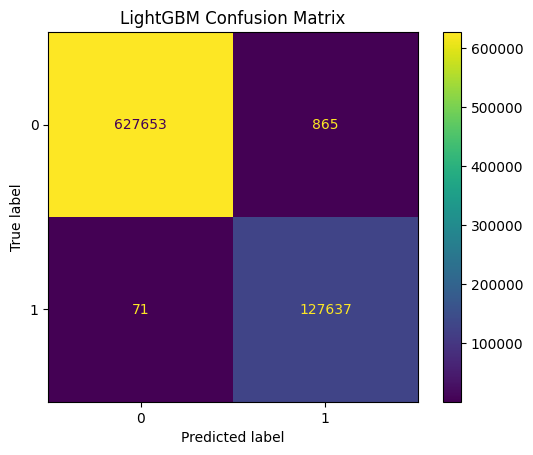

In [ ]:
lgbm_confusion = confusion_matrix(y_test, y_pred)
lgbm_cm_display = ConfusionMatrixDisplay(
    confusion_matrix=lgbm_confusion, display_labels=[0, 1]
)

lgbm_cm_display.plot()
plt.title("LightGBM Confusion Matrix")
plt.show()

In [145]:
import pickle

file_name = "lgbm_cicids2017.pkl"

# save
pickle.dump(best_lgbm, open(file_name, "wb"))
